In [65]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

# Если переменная BASE_DIR не определена, то устанавливаем её как текущий каталог
if not 'BASE_DIR' in locals():
    BASE_DIR = os.path.abspath(os.curdir)

In [66]:
# Если текущий каталог является BASE_DIR, то переходим на уровень выше
if os.path.abspath(os.curdir) == BASE_DIR:
    os.chdir('../')

# Определяем путь к каталогу с данными
dirname = os.path.abspath(os.curdir) + r'\data'

# Читаем данные из CSV файла
df = pd.read_csv(path.join(os.sep, dirname, 'Annual snowfall in Chicago 1939 to 1978.csv'))

# Оставляем только колонку 'x'
df = df['x']
df.head()

0    33.9
1    31.0
2    52.5
3    29.8
4    45.2
Name: x, dtype: float64

In [67]:
df.describe()

count    40.000000
mean     41.442500
std      15.714584
min      14.300000
25%      30.700000
50%      38.000000
75%      52.275000
max      82.300000
Name: x, dtype: float64

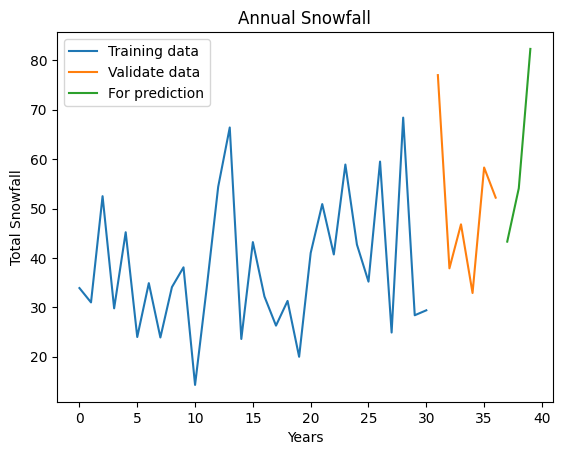

In [68]:
# Определяем размеры выборок
ln = len(df)
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# Делим данные на обучающую, валидационную и тестовую выборки
train_df = df[df.index<= train_cutoff]
validate_df = df[(df.index> train_cutoff) & (df.index<= validate_cutoff)]
forecast_df = df[df.index> validate_cutoff]

# Выводим график данных
plt.plot(train_df.index, train_df, label='Training data')
plt.plot(validate_df.index, validate_df, label='Validate data')
plt.plot(forecast_df.index, forecast_df, label='For prediction')
plt.legend()
plt.title('Annual Snowfall')
plt.ylabel('Total Snowfall')
plt.xlabel('Years')
plt.show()

In [69]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ARMA модель (используя SARIMAX с d=0)
arma_model = SARIMAX(train_df, order=(2, 0, 1))
arma_result = arma_model.fit(disp=False)

# ARIMA модель
arima_model = ARIMA(train_df, order=(2, 1, 2))
arima_result = arima_model.fit()

C:\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [70]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# Предсказываем значения на тестовом наборе данных
arma_predictions = arma_result.predict(start=len(train_df), end=len(train_df) + len(validate_df)-1, dynamic=False)
arima_predictions = arima_result.predict(start=len(train_df), end=len(train_df) + len(validate_df)-1, dynamic=False)

# Оцениваем метрики
print("ARMA")
print("RMSE:", np.sqrt(mean_squared_error(validate_df, arma_predictions)))
print("MAPE:", mean_absolute_percentage_error(validate_df, arma_predictions))
print("MAE:", mean_absolute_error(validate_df, arma_predictions))
print("R2: ", r2_score(validate_df, arma_predictions))
print("SMAPE:", smape(validate_df, arma_predictions))

print("ARIMA")
print("RMSE:", np.sqrt(mean_squared_error(validate_df, arima_predictions)))
print("MAPE:", mean_absolute_percentage_error(validate_df, arima_predictions))
print("MAE:", mean_absolute_error(validate_df, arima_predictions))
print("R2: ", r2_score(validate_df, arima_predictions))
print("SMAPE:", smape(validate_df, arima_predictions))

ARMA
RMSE: 18.343985464007346
MAPE: 0.24018130012169467
MAE: 14.071919734259737
R2:  -0.6185039269731385
SMAPE: 28.283323588416913
ARIMA
RMSE: 14.569389722832497
MAPE: 0.19199442606088554
MAE: 11.184247677293195
R2:  -0.020960837364604856
SMAPE: 22.03770366978241


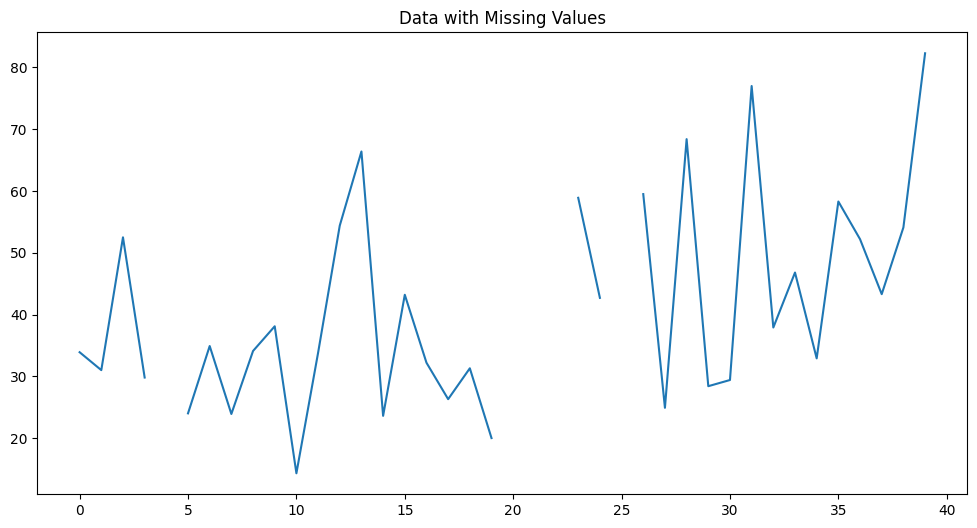

In [71]:
# Создаем копию данных
df_with_nan = df.copy()

# Вставляем пропуски
np.random.seed(0)
nan_indices = np.random.choice(df_with_nan.index, size=int(0.1 * len(df_with_nan)), replace=False)
df_with_nan.loc[nan_indices] = np.nan

# График данных с пропусками
plt.figure(figsize=(12,6))
plt.plot(df_with_nan)
plt.title('Data with Missing Values')
plt.show()

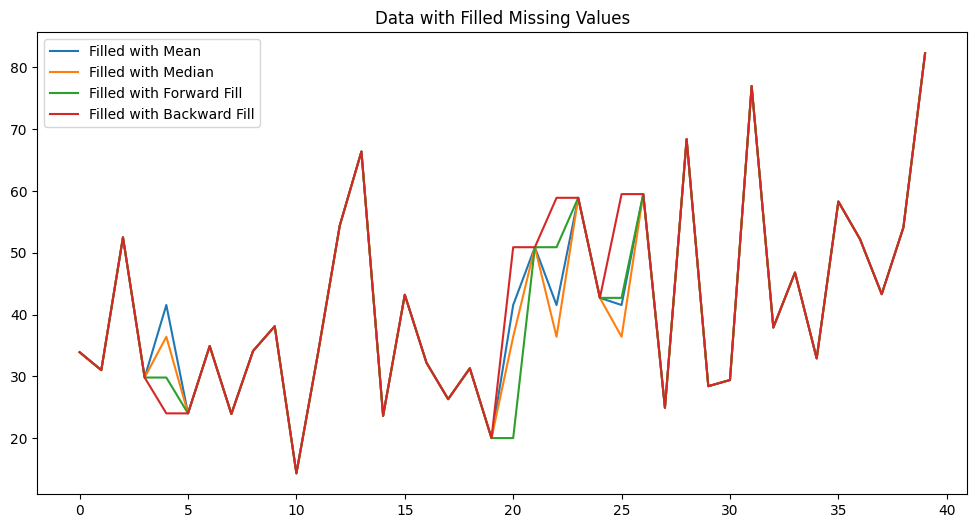

In [72]:
# Заполняем пропуски средним значением
df_filled_mean = df_with_nan.fillna(df_with_nan.mean())

# Заполняем пропуски медианой
df_filled_median = df_with_nan.fillna(df_with_nan.median())

# Заполняем пропуски последним известным значением
df_filled_forward = df_with_nan.fillna(method='ffill')

# Заполняем пропуски следующим известным значением
df_filled_backward = df_with_nan.fillna(method='bfill')

# Графики данных с заполненными пропусками
plt.figure(figsize=(12,6))
plt.plot(df_filled_mean, label='Filled with Mean')
plt.plot(df_filled_median, label='Filled with Median')
plt.plot(df_filled_forward, label='Filled with Forward Fill')
plt.plot(df_filled_backward, label='Filled with Backward Fill')
plt.legend()
plt.title('Data with Filled Missing Values')
plt.show()

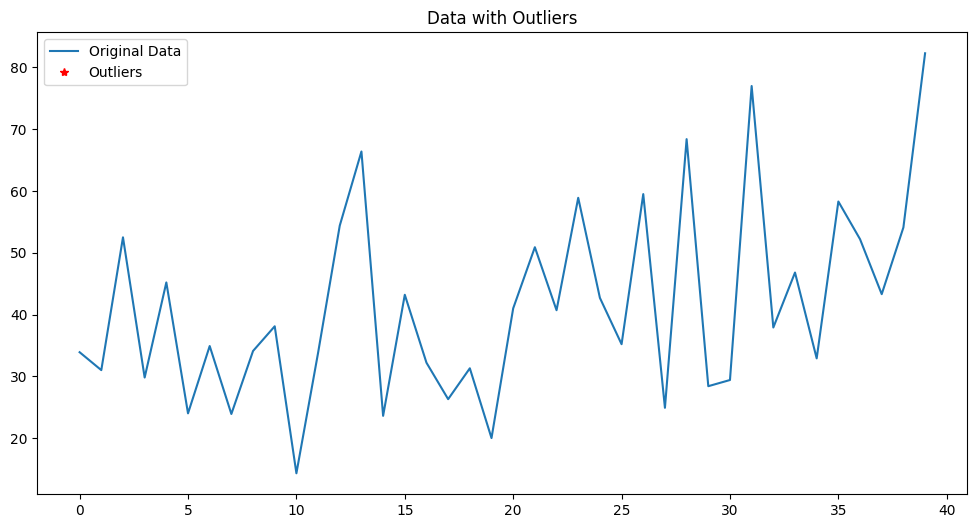

In [73]:
# Используем метод межквартильного размаха для определения выбросов
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))]

# График данных с выбросами
plt.figure(figsize=(12,6))
plt.plot(df, label='Original Data')
plt.plot(outliers, 'r*', label='Outliers')
plt.legend()
plt.title('Data with Outliers')
plt.show()


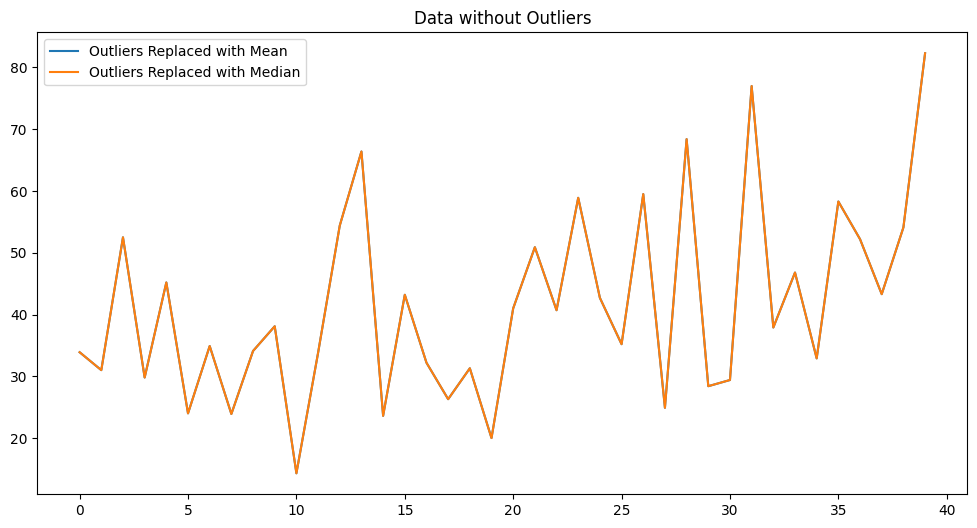

In [74]:
# Заменяем выбросы средним значением
df_no_outliers_mean = df.copy()
df_no_outliers_mean[outliers.index] = df.mean()

# Заменяем выбросы медианой
df_no_outliers_median = df.copy()
df_no_outliers_median[outliers.index] = df.median()

# Графики данных без выбросов
plt.figure(figsize=(12,6))
plt.plot(df_no_outliers_mean, label='Outliers Replaced with Mean')
plt.plot(df_no_outliers_median, label='Outliers Replaced with Median')
plt.legend()
plt.title('Data without Outliers')
plt.show()